# NCVotingProd: NCVotingLearn model production notebook
### Notebook explores production possibilities for the NC Voting Prediction Model and isolates false negative and positive cases for additional exploration

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import pickle
from sklearn.externals import joblib

import os
import time
import sys

In [2]:
# data load -- preprocessing ref. is NCVotingLearn_Final
df0301 = pd.read_csv("dfIIA.dat", sep = '|')
df0301.head()

,Unnamed: 0,ncid,county,gender,age,race,party,rYear,vdex,vmethod,11022004,11072006,11042008,11022010,11062012,11042014,11082016,11062018
0,0,AA56273,1,F,83,W,UNA,1984,1.0,0.875,1,1,1,1,1,1,1,1
1,1,AA201627,1,F,40,W,UNA,2018,0.0,0.000,0,0,0,0,0,0,0,0
2,2,AA98377,1,F,42,W,UNA,1996,1.0,0.500,1,1,1,1,1,1,1,1
3,3,AA69747,1,F,73,W,UNA,1989,1.0,0.250,1,1,1,1,1,1,1,1
4,4,AA170513,1,M,70,W,DEM,2012,1.0,0.000,0,0,0,0,1,1,1,1


In [ ]:
cat_cols = [
    "gender",
    "race",
    "party",
    "11022004",
    "11072006",
    "11042008",
    "11022010",
    "11062012",
    "11042014",
    "11082016",
    "11062018"
]

In [ ]:
num_cols = [
    "vdex",
    "vmethod",
    "age"
   # "ballots"
]

In [ ]:
df0301.vdex.value_counts()

In [ ]:
df0301.columns

In [5]:
features_to_use = [
    "age",
    #"birth_state",
    "gender",
    "race",
    "party",
    "vdex",
    "vmethod",
    "11022004",
    "11072006",
    "11042008",
    "11022010",
    "11062012",
    "11042014",
    "11082016"
]

In [6]:
X = df0301[features_to_use]

In [7]:
X.shape

(7421374, 13)

In [9]:
X_encoded = pd.get_dummies(X)

In [10]:
X_encoded.shape

(7421374, 28)

In [11]:
X_encoded.head()

,age,vdex,vmethod,11022004,11072006,11042008,11022010,11062012,11042014,11082016,...,race_M,race_O,race_U,race_W,party_CST,party_DEM,party_GRE,party_LIB,party_REP,party_UNA
0,83,1.0,0.875,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,1
1,40,0.0,0.000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,42,1.0,0.500,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,1
3,73,1.0,0.250,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,1
4,70,1.0,0.000,0,0,0,0,1,1,1,...,0,0,0,1,0,1,0,0,0,0


In [12]:
del X_encoded['race_ '] #this was necessary due to a drop made in 2nd train test split -- unknown origin

## df0301 is prepped for model introduction.

- X_encoded can skip TTS processing
- load clf from NC_Predicted_TO18.model
- load sds from NC_Predict_TO18_scalar.model
- Proceeds to standardScaler
- makes predictions

In [13]:
# load stored model classification (clf)
clf = joblib.load("NC_Predict_TO18.model")

In [14]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [15]:
# load stored model scalar (sds)
sds = joblib.load("NC_Predict_TO18_scaler.model")

In [16]:
sds

StandardScaler(copy=True, with_mean=True, with_std=True)

In [30]:
scaled_features = sds.transform(X_encoded)
print(scaled_features)

[[ 1.6935506   1.02871672  1.18813915 ... -0.07323142 -0.65414538
   1.49055437]
 [-0.51923837 -1.74551342 -1.08526206 ... -0.07323142 -0.65414538
   1.49055437]
 [-0.41631796  1.02871672  0.21382435 ... -0.07323142 -0.65414538
   1.49055437]
 ...
 [ 0.66434642 -1.74551342 -1.08526206 ... -0.07323142 -0.65414538
   1.49055437]
 [ 2.05377206 -0.70517711 -1.08526206 ... -0.07323142 -0.65414538
  -0.67089133]
 [ 0.20120455 -1.74551342 -1.08526206 ... -0.07323142  1.52871217
  -0.67089133]]


In [18]:
vpred = clf.predict(scaled_features)
vpred_prob = clf.predict_proba(scaled_features)
vpred_prob

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [19]:
vpred

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [20]:
vpred.sum()

3738303

### Predicted voting of 3,738,303 vs. 3,755,778 actual shows whole error of -17,475 (-0.47%)

In [77]:
probVotes = pd.DataFrame(vpred_prob)
predVotes = pd.DataFrame(vpred, columns={'pvote'})

In [78]:
test_r = df0301.join(predVotes)
test_r.head()

,Unnamed: 0,ncid,county,gender,age,race,party,rYear,vdex,vmethod,11022004,11072006,11042008,11022010,11062012,11042014,11082016,11062018,pvote
0,0,AA56273,1,F,83,W,UNA,1984,1.0,0.875,1,1,1,1,1,1,1,1,1
1,1,AA201627,1,F,40,W,UNA,2018,0.0,0.000,0,0,0,0,0,0,0,0,0
2,2,AA98377,1,F,42,W,UNA,1996,1.0,0.500,1,1,1,1,1,1,1,1,1
3,3,AA69747,1,F,73,W,UNA,1989,1.0,0.250,1,1,1,1,1,1,1,1,1
4,4,AA170513,1,M,70,W,DEM,2012,1.0,0.000,0,0,0,0,1,1,1,1,1


In [69]:
FPTot =  test_r.groupby(['11062018'])['pvote'].sum()
FPTot

11062018
0      65864
1    3672439
Name: pvote, dtype: int64

In [70]:
FPPct = test_r.groupby(['11062018'])['pvote'].mean()*100
FPPct

11062018
0     1.795228
1    97.865497
Name: pvote, dtype: float64

### Predicted voting of 3,738,303 shows 65,864 (1.8%) False Positive State

In [79]:
FNTot = test_r.groupby(['pvote'])['11062018'].sum()
FNTot

pvote
0      80098
1    3672439
Name: 11062018, dtype: int64

In [80]:
FNPct =  test_r.groupby(['pvote'])['11062018'].mean()*100
FNPct

pvote
0     2.174761
1    98.238131
Name: 11062018, dtype: float64

### Predicted voting of 3,738,303 shows 80,098 (2.2%) False Negative State

## Create and plot Confusion Matrix based on scikit-learn documentation code ##

In [73]:
y_actual = test_r['11062018']
y_pred = predVotes['pvote']
class_names = y_pred.values

Confusion matrix, without normalization
[[3602973   65864]
 [  80098 3672439]]
Normalized confusion matrix
[[0.98 0.02]
 [0.02 0.98]]


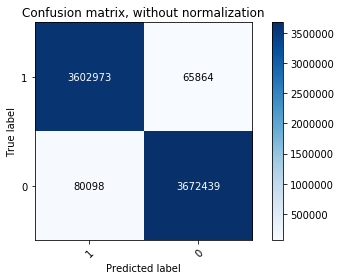

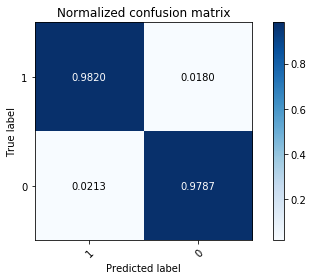

In [89]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_actual, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # calculate confusion matrix
    cm = confusion_matrix(y_actual, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_actual, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_actual, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_actual, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Isolate False Positive and False Negative rows to dfs

In [75]:
# false positives for exploration
FPdf = test_r.loc[test_r['11062018'] < test_r['pvote']]
FPdf.head()

,Unnamed: 0,ncid,county,gender,age,race,party,rYear,vdex,vmethod,11022004,11072006,11042008,11022010,11062012,11042014,11082016,11062018,pvote
16,16,DE236758,1,M,29,O,UNA,2014,0.333333,1.0,0,0,1,0,0,0,0,0,1
305,305,BD95809,1,M,53,W,REP,2016,0.500000,1.0,0,0,1,0,0,0,0,0,1
506,507,AA188046,1,F,20,O,DEM,2018,1.000000,1.0,0,0,0,0,0,0,1,0,1
530,532,AA191695,1,M,56,U,DEM,2016,0.500000,1.0,0,0,0,0,0,0,1,0,1
768,770,DS89198,1,F,31,W,UNA,2017,1.000000,0.0,0,0,0,0,0,0,1,0,1


In [76]:
false negatives for exploration
FNdf = test_r.loc[test_r['11062018'] > test_r['pvote']]
FNdf.head()

,Unnamed: 0,ncid,county,gender,age,race,party,rYear,vdex,vmethod,11022004,11072006,11042008,11022010,11062012,11042014,11082016,11062018,pvote
14,14,AA162459,1,F,67,W,REP,2008,0.333333,1.000000,0,0,0,0,0,0,1,1,0
64,64,DR80381,1,F,54,W,UNA,2015,1.000000,0.333333,0,1,1,1,0,1,1,1,0
90,90,BY517955,1,M,55,B,DEM,2017,1.000000,0.000000,0,0,1,0,0,0,1,1,0
171,171,AA2083,1,M,63,W,UNA,1980,0.250000,0.000000,0,0,0,0,0,0,1,1,0
183,183,BN330809,1,M,33,W,UNA,2012,1.000000,1.000000,1,0,1,0,0,0,1,1,0


### Load cutdown version of voters set for access to additional voter data including precinct and zip5 geography, ethnic coding and birth state.

In [87]:
votersFinal = pd.read_csv('votersFinal.dat',  sep='|', dtype={ 'zip_code': 'str',
                                                              'ncid': 'str',
                                                              'vtd_abbr': 'str',
                                                              'voter_reg_num': 'str',
                                                              'ballots': 'int'
                                                             })

C:\Users\selli\Anaconda36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [88]:
del votersFinal['Unnamed: 0']
votersFinal.head()

,ncid,county_id,vtd_abbrv,zip_code,gender_code,birth_age,race_code,ethnic_code,party_cd,birth_state,rYear,eligible,ballots,vdex
0,AA56273,1,08N,27253.0,F,83,W,NL,UNA,NY,1984,8,8,1.0
1,AA201627,1,10N,27302.0,F,40,W,UN,UNA,DC,2018,1,0,0.0
2,AA98377,1,03S,27215.0,F,42,W,UN,UNA,NC,1996,8,8,1.0
3,AA69747,1,124,27215.0,F,73,W,NL,UNA,VA,1989,8,8,1.0
4,AA170513,1,08N,27253.0,M,70,W,UN,DEM,MA,2012,4,4,1.0


### Additional exploration will begin with a look at False Negative cases.